In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [ ]:
nfs = [8,16,32,64,64]

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

train: [0.974661953125, tensor(0.6818, device='cuda:0')]
valid: [0.17374559326171876, tensor(0.9478, device='cuda:0')]
train: [0.156173408203125, tensor(0.9516, device='cuda:0')]
valid: [0.111946533203125, tensor(0.9652, device='cuda:0')]
CPU times: user 4.08 s, sys: 1.59 s, total: 5.67 s
Wall time: 7.15 s


## Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [ ]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [ ]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

train: [0.25301349609375, tensor(0.9210, device='cuda:0')]
valid: [0.1441773193359375, tensor(0.9583, device='cuda:0')]


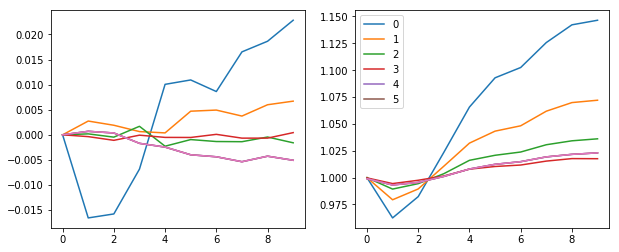

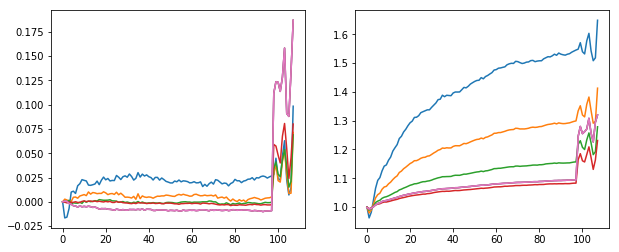

In [ ]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [ ]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.24493619140625, tensor(0.9240, device='cuda:0')]
valid: [0.2907875244140625, tensor(0.9040, device='cuda:0')]
train: [0.087912919921875, tensor(0.9721, device='cuda:0')]
valid: [0.09330442504882812, tensor(0.9716, device='cuda:0')]
train: [0.063085654296875, tensor(0.9800, device='cuda:0')]
valid: [0.10683492431640625, tensor(0.9676, device='cuda:0')]
CPU times: user 3.84 s, sys: 481 ms, total: 4.32 s
Wall time: 4.32 s


### jit

To make it faster we will now use PyTorch JIT module. Basically, it parses the python code we type and reintrepret it in C to make it faster. This is still in development so there are many rough edges.

In [ ]:
#export
from torch.jit import ScriptModule, script_method, script
from typing import *

In [ ]:
@script
def bn_update_stats(x, means, vars, mom:float=0.1, eps:float=1e-5):
    m, invstd = torch.batch_norm_stats(x, eps)
    views = (1,-1,1,1)
    m = m.view(*views)
    v = (invstd.view(*views)**-2)
    means.copy_(m.lerp(means, mom))
    vars .copy_(v.lerp(vars , mom))
    return m,v+eps

@script
def bn_transform_input1(means, vars, mults, adds):
    factor = mults/(vars+1e-5).sqrt()
    return factor, adds - means*factor

@script
def bn_transform_input2(x, factor, offset):
    # note result = x * factor + offset is backpropagationally more efficient
    # than having an inner addition and then the multiplication
    # because we can caluclate the backward of x * factor + offset by
    # just using x, factor, and the gradient w.r.t. result
    return x * factor + offset

class BatchNormJit(torch.nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mults = torch.nn.Parameter(torch.ones (1,nf,1,1))
        self.adds  = torch.nn.Parameter(torch.zeros(1,nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.mom,self.eps = mom,eps

    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m,v = bn_update_stats(x, self.means, self.vars, self.mom, self.eps)
        else: m,v = self.means,self.vars
        factor,offset = bn_transform_input1(m, v, self.mults, self.adds)
        return bn_transform_input2(x, factor, offset)

In [ ]:
def conv_jit(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNormJit(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 1.0, conv_jit, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.24827685546875, tensor(0.9229, device='cuda:0')]
valid: [0.10256734619140626, tensor(0.9675, device='cuda:0')]
train: [0.083638310546875, tensor(0.9737, device='cuda:0')]
valid: [0.13344407958984375, tensor(0.9584, device='cuda:0')]
train: [0.060942275390625, tensor(0.9809, device='cuda:0')]
valid: [0.06848046875, tensor(0.9788, device='cuda:0')]
CPU times: user 3.9 s, sys: 472 ms, total: 4.37 s
Wall time: 4.38 s


### Builtin batchnorm

In [ ]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.2787950390625, tensor(0.9191, device='cuda:0')]
valid: [0.09700962524414063, tensor(0.9697, device='cuda:0')]
train: [0.076595166015625, tensor(0.9766, device='cuda:0')]
valid: [0.06428272705078125, tensor(0.9798, device='cuda:0')]
train: [0.0517351025390625, tensor(0.9839, device='cuda:0')]
valid: [0.05599977416992188, tensor(0.9814, device='cuda:0')]
CPU times: user 3.5 s, sys: 554 ms, total: 4.06 s
Wall time: 4.06 s


### With scheduler

Now let's add the usual warm-up/annealing.

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_lin(0.4, 1.), sched_lin(1., 0.2)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [ ]:
run.fit(8, learn)

train: [0.3243235546875, tensor(0.9038, device='cuda:0')]
valid: [0.16111353759765626, tensor(0.9516, device='cuda:0')]
train: [0.110108037109375, tensor(0.9664, device='cuda:0')]
valid: [0.1830513671875, tensor(0.9423, device='cuda:0')]
train: [0.08164703125, tensor(0.9745, device='cuda:0')]
valid: [0.1907194580078125, tensor(0.9396, device='cuda:0')]
train: [0.067421171875, tensor(0.9784, device='cuda:0')]
valid: [0.09536594848632812, tensor(0.9721, device='cuda:0')]
train: [0.0527210400390625, tensor(0.9837, device='cuda:0')]
valid: [0.06462601928710937, tensor(0.9811, device='cuda:0')]
train: [0.042901416015625, tensor(0.9869, device='cuda:0')]
valid: [0.0690087890625, tensor(0.9795, device='cuda:0')]
train: [0.03598960693359375, tensor(0.9892, device='cuda:0')]
valid: [0.05560814208984375, tensor(0.9833, device='cuda:0')]
train: [0.03057737548828125, tensor(0.9912, device='cuda:0')]
valid: [0.05029096069335937, tensor(0.9854, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In [ ]:
class LayerNorm(ScriptModule):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    @script_method
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.std ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [ ]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.484382421875, tensor(0.8470, device='cuda:0')]
valid: [0.1195010498046875, tensor(0.9664, device='cuda:0')]
train: [0.11501509765625, tensor(0.9643, device='cuda:0')]
valid: [0.0873831298828125, tensor(0.9735, device='cuda:0')]
train: [0.069044267578125, tensor(0.9777, device='cuda:0')]
valid: [0.07121566162109375, tensor(0.9785, device='cuda:0')]
CPU times: user 4.19 s, sys: 511 ms, total: 4.7 s
Wall time: 4.7 s


*Thought experiment*: can this distinguish cloudy days from sunny days (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [ ]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.std ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [ ]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.79 s, sys: 726 ms, total: 5.51 s
Wall time: 5.52 s


*Question*: why can't this classify anything?

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

### Group norm

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: :math:`(N, num\_channels, *)`
- Output: :math:`(N, num\_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [ ]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [2.32052890625, tensor(0.2005, device='cuda:0')]
valid: [5.079162109375, tensor(0.3243, device='cuda:0')]
CPU times: user 1min 42s, sys: 8.42 s, total: 1min 50s
Wall time: 1min 51s


### Exponentially Weighted Batch Norm

In [ ]:
class EWBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        self.mom1 = self.dbias.new_tensor(1 - (1-self.mom)**bs)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias.lerp_(self.mom1, self.mom1)
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [ ]:
def conv_ewbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(EWBatchNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_ewbn, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [0.4411913671875, tensor(0.8844, device='cuda:0')]
valid: [0.14587576904296876, tensor(0.9660, device='cuda:0')]
CPU times: user 4min 11s, sys: 22.5 s, total: 4min 34s
Wall time: 4min 34s


### What can we do in a single epoch?

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.9, conv_ewbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [ ]:
%time run.fit(1, learn)

train: [0.172372578125, tensor(0.9456, device='cuda:0')]
valid: [0.07145625610351562, tensor(0.9785, device='cuda:0')]
CPU times: user 17.5 s, sys: 1.46 s, total: 18.9 s
Wall time: 18.9 s


## Export

In [ ]:
nb_auto_export()

<IPython.core.display.Javascript object>